<a href="https://colab.research.google.com/github/hmorgancooper/LSTM_RNN_weather_prediction/blob/main/LSTM_RNN_Weather_timeseries_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LSTM RNN used to predict day-ahead weather forecast

This notebook contains a one-shot 24 hour weather prediction.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import tensorflow as tf
import seaborn as sns


In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 [==============================] - 0s 0us/step


## Data Exploration and cleaning

In [3]:
df = pd.read_csv(csv_path)

In [4]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


Let's take a look at the dataframe.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [6]:
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,989.212776,9.450147,283.492743,4.955854,76.008259,13.576251,9.533756,4.042412,6.022408,9.640223,1216.062748,1.702224,3.056555,174.743738
std,8.358481,8.423365,8.504471,6.730674,16.476175,7.739020,4.184164,4.896851,2.656139,4.235395,39.975208,65.446714,69.016932,86.681693
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.900000
50%,989.580000,9.420000,283.470000,5.220000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.790000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.490000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,28.490000,23.500000,360.000000


 Checking for NaN values

In [7]:
df.isnull().sum()

Date Time          0
p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

Let's convert the Date Time column to datetime.

In [8]:
df['Date Time'] = pd.to_datetime(df['Date Time'])

And let's take a look at the distribution of all the variables

In [9]:
def box_plot_all(df, nrows, ncols):
  count = 0
  columns = list(df.select_dtypes(include=np.number).columns)
  fig, axes = plt.subplots(nrows, ncols, figsize=(15, 10))
  for i in range(nrows):
    for j in range(ncols):
      sns.boxplot(y = df[columns[count]], ax=axes[i, j])
      count += 1
  plt.tight_layout() 

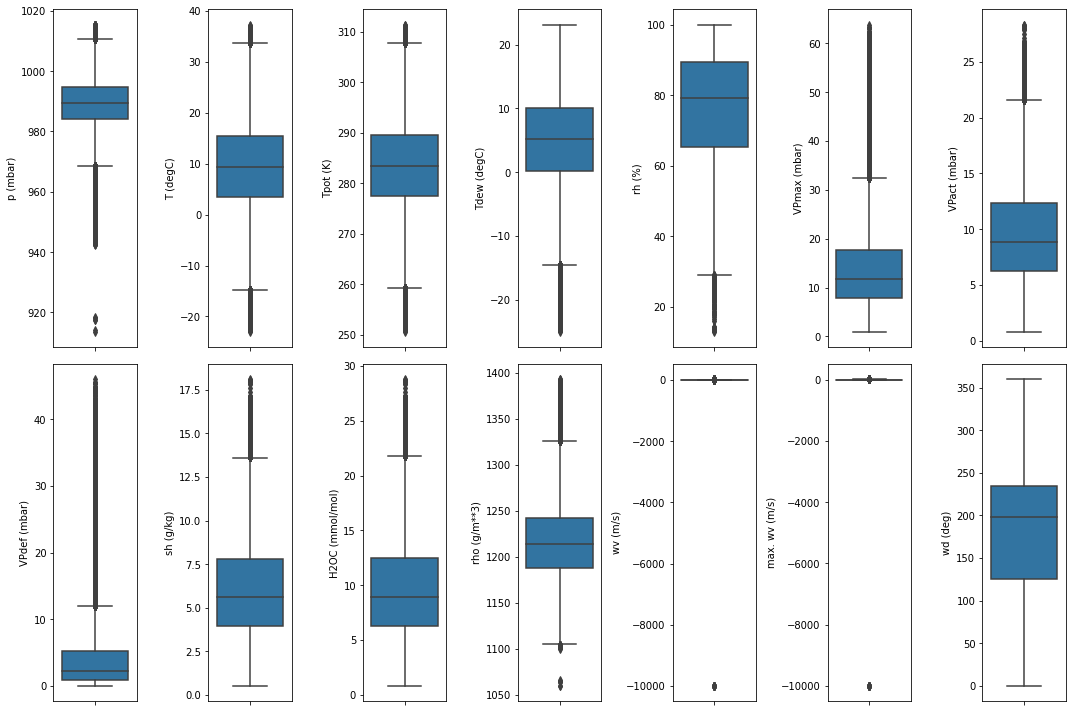

In [10]:
box_plot_all(df, nrows=2, ncols=7)

So most of the distributions look sensible, but both the wind speeds have some pretty large outliers. It looks like these are errors since they are negative and there is a wind direction column. Let's see how much of the data these account for.

In [11]:
df[(df['wv (m/s)'] < 0) | (df['max. wv (m/s)'] < 0)]

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
343577,2015-07-13 09:00:00,990.52,16.98,290.93,12.94,77.10,19.38,14.94,4.44,9.44,15.09,1182.50,6.16,-9999.0,289.6
343578,2015-07-13 09:10:00,990.49,16.85,290.80,12.78,76.90,19.22,14.78,4.44,9.34,14.92,1183.06,-9999.00,-9999.0,359.7
343579,2015-07-13 09:20:00,990.32,17.06,291.03,12.86,76.30,19.48,14.86,4.62,9.39,15.01,1181.97,-9999.00,-9999.0,359.8
343580,2015-07-13 09:30:00,990.24,17.43,291.41,12.75,74.00,19.94,14.76,5.19,9.32,14.90,1180.42,-9999.00,-9999.0,359.8
343581,2015-07-13 09:40:00,990.27,17.71,291.68,12.88,73.30,20.30,14.88,5.42,9.40,15.02,1179.26,-9999.00,-9999.0,359.8
343582,2015-07-13 09:50:00,990.28,17.76,291.73,13.03,73.80,20.36,15.03,5.33,9.49,15.17,1179.00,-9999.00,-9999.0,359.8
343583,2015-07-13 10:00:00,990.20,17.98,291.96,12.74,71.40,20.65,14.74,5.90,9.31,14.89,1178.14,-9999.00,-9999.0,359.8
343584,2015-07-13 10:10:00,990.17,18.19,292.17,12.59,69.78,20.92,14.60,6.32,9.22,14.74,1177.32,-9999.00,-9999.0,359.8
343585,2015-07-13 10:20:00,990.07,18.31,292.30,12.97,71.00,21.08,14.97,6.11,9.46,15.12,1176.55,-9999.00,-9999.0,359.8
343586,2015-07-13 10:30:00,990.02,18.24,292.24,12.88,70.90,20.99,14.88,6.11,9.40,15.03,1176.82,-9999.00,-9999.0,359.8


So only looks like entries between 9am and 12pm for one day, let's set these values to the values from the day before. That way we don't skew the results by setting the values to 0, and we still maintain the data stream. 

In [12]:
date_times = set(df[(df['wv (m/s)'] < 0)]['Date Time'])
date_2 = set(df[(df['max. wv (m/s)'] < 0)]['Date Time'])
date_times.update(date_2)

In [13]:
for date in date_times:
  new_wv = df[df["Date Time"] == (date - dt.timedelta(days=1))]['wv (m/s)']
  df.loc[df['Date Time'] == date, ['wv (m/s)']] = float(new_wv)
  new_max_wv = df[df["Date Time"] == (date - dt.timedelta(days=1))]['max. wv (m/s)']
  df.loc[df['Date Time'] == date, ['max. wv (m/s)']] = float(new_wv)

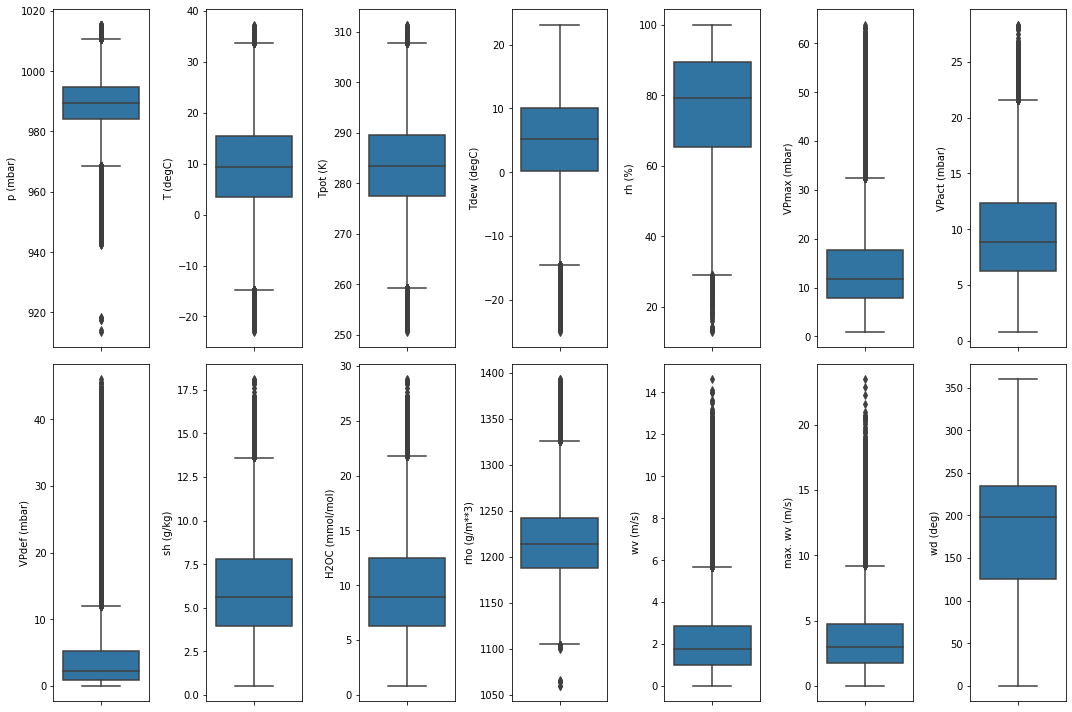

In [14]:
box_plot_all(df, nrows=2, ncols=7)

Distrubution looks good! 

## Data Preprocessing
Feature engineering, normalisation

Weather is very cyclical with time of day and time of year so let's add these as variables. However, we want the model to know that Dec 31st is close to Jan 1st, and that 11:59pm is close to 00:00am so we cannot just plug in day of year or time of day.
Instead we will convert these to sine waves.
 
A modified sine wave has formula:
sin(y) = sin(B(x - c))

For day of year we want to set B so that the period is 365 days, and c so the peak is at 172 days. 

B = 2*pi/365

Normally the peak is at pi/2 so to find c:

pi/2 = 2*pi/365(173 - c)

c = 81.75



In [15]:
df['day_of_year'] = df['Date Time'].apply(lambda x: x.timetuple().tm_yday)
df['hour_in_day'] = df['Date Time'].apply(lambda x: x.timetuple().tm_hour)

In [16]:
import math
df['year_sin'] = df['day_of_year'].apply(lambda x: math.sin(2*math.pi/365*(x - 81.75)))
df['day_sin'] = df['hour_in_day'].apply(lambda x: math.sin(2*math.pi/24*(x)))

We will check these after we group the data into hour intervals

In [17]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),day_of_year,hour_in_day,year_sin,day_sin
0,2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3,1,0,-0.983709,0.0
1,2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1,1,0,-0.983709,0.0
2,2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6,1,0,-0.983709,0.0
3,2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0,1,0,-0.983709,0.0
4,2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3,1,0,-0.983709,0.0


wd(deg) shows the direction of the wind - this is probably not necessary so let's drop that column

In [18]:
df = df.drop('wd (deg)', axis=1)

Now let's group the data by hour as 10 minute intervals seems like too much fine detail.

In [19]:
df = df.groupby(pd.Grouper(key='Date Time', freq='h')).mean()
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),day_of_year,hour_in_day,year_sin,day_sin
Date Time,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,996.528000,-8.304000,265.118000,-9.120000,93.780000,3.260000,3.058000,0.202000,1.910000,3.068000,1309.196000,0.520000,1.002000,1.0,0.0,-0.983709,0.000000
2009-01-01 01:00:00,996.525000,-8.065000,265.361667,-8.861667,93.933333,3.323333,3.121667,0.201667,1.951667,3.133333,1307.981667,0.316667,0.711667,1.0,1.0,-0.983709,0.258819
2009-01-01 02:00:00,996.745000,-8.763333,264.645000,-9.610000,93.533333,3.145000,2.940000,0.201667,1.836667,2.950000,1311.816667,0.248333,0.606667,1.0,2.0,-0.983709,0.500000
2009-01-01 03:00:00,996.986667,-8.896667,264.491667,-9.786667,93.200000,3.111667,2.898333,0.210000,1.811667,2.906667,1312.813333,0.176667,0.606667,1.0,3.0,-0.983709,0.707107
2009-01-01 04:00:00,997.158333,-9.348333,264.026667,-10.345000,92.383333,3.001667,2.775000,0.231667,1.733333,2.780000,1315.355000,0.290000,0.670000,1.0,4.0,-0.983709,0.866025


Let's check nothing funny happened...

In [20]:
df.isnull().sum()

p (mbar)           88
T (degC)           88
Tpot (K)           88
Tdew (degC)        88
rh (%)             88
VPmax (mbar)       88
VPact (mbar)       88
VPdef (mbar)       88
sh (g/kg)          88
H2OC (mmol/mol)    88
rho (g/m**3)       88
wv (m/s)           88
max. wv (m/s)      88
day_of_year        88
hour_in_day        88
year_sin           88
day_sin            88
dtype: int64

In [21]:
set(df[df['p (mbar)'].isnull()].index.date)

{datetime.date(2014, 9, 24),
 datetime.date(2014, 9, 25),
 datetime.date(2016, 10, 25),
 datetime.date(2016, 10, 26),
 datetime.date(2016, 10, 27),
 datetime.date(2016, 10, 28)}

There are some null values. From looking at the original dataframe, these are caused by hour long time intervals with no data. To fix these let's set all null values to the value from the day before. Some of the days with nulls are consecutive so the earliest non null value will be used for all the dates. 

In [22]:
indexes = df[df['p (mbar)'].isnull()].index

In [23]:
for index in indexes:
  df.loc[index] = df.loc[index - dt.timedelta(days=1)]

In [24]:
df.isnull().sum()

p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
day_of_year        0
hour_in_day        0
year_sin           0
day_sin            0
dtype: int64

Ok, looks good. Let's check take a look at each of the variables.

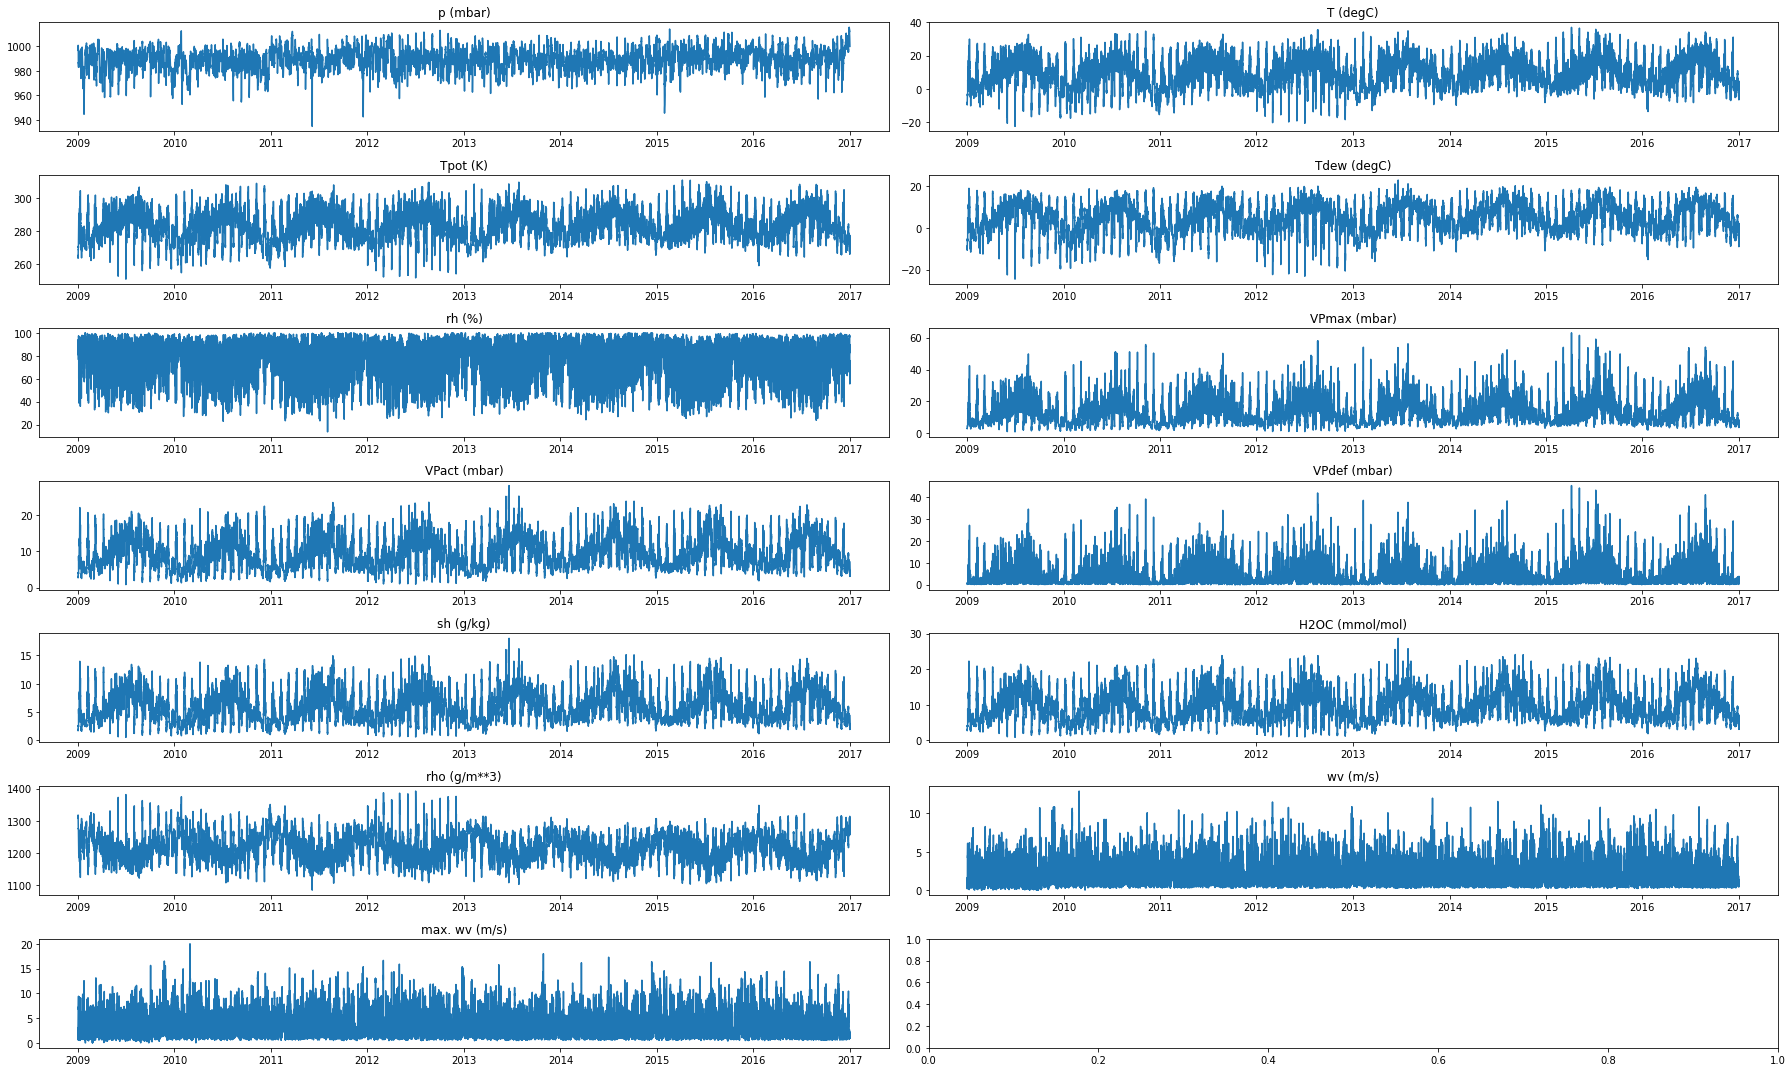

In [25]:
numrows=7
numcols=2
count=0
cols_to_plot = df.columns.drop(['day_of_year', 'hour_in_day', 'day_sin', 'year_sin'])
fig, axes = plt.subplots(numrows, numcols, figsize = (25, 15))
for i in range(numrows):
  for j in range(numcols):
    if count >= len(df.columns.drop(['day_of_year', 'hour_in_day', 'day_sin', 'year_sin'])):
      break;
    axes[i, j].plot(df[cols_to_plot[count]])
    axes[i,j].set_title(cols_to_plot[count])
    count+=1
    
plt.tight_layout()


Now let's look at out day and year sine curves over one day and one year respectively.

Text(0.5, 1.0, 'Day sine over one day')

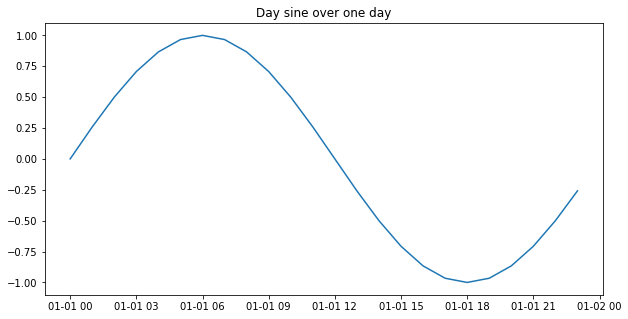

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(df[:24]['day_sin'])
plt.title('Day sine over one day')

Text(0.5, 1.0, 'Year sine over one year')

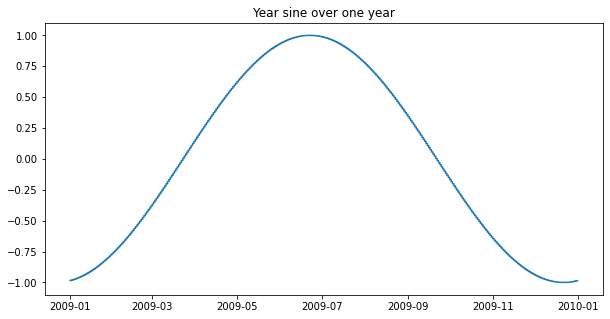

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(df[:24*365]['year_sin'])
plt.title('Year sine over one year')

## Splitting the data into train, test, validation sets

Here we will divide the data. Unlike other types of modelling we won't split the data randomly as for timeseries data like this what came before is important.

In [28]:
train_split = 0.7
test_split = 0.2
validation_split = 1 - train_split - test_split

train_end = int(len(df)*train_split)
test_end = int(len(df)*(train_split + test_split))

df_train = df.copy()[ :train_end]
df_test = df.copy()[train_end: test_end]
df_validation = df.copy()[test_end: ]

In [29]:
print(f"train range is {df_train.index.min()}: {df_train.index.max()}")
print(f"test range is {df_test.index.min()}: {df_test.index.max()}")
print(f"validation range is {df_validation.index.min()}: {df_validation.index.max()}")

train range is 2009-01-01 00:00:00: 2014-08-08 09:00:00
test range is 2014-08-08 10:00:00: 2016-03-14 19:00:00
validation range is 2016-03-14 20:00:00: 2017-01-01 00:00:00


## Normalising the Data

Normalising the data gives each input to the network an equal importance as the network is sensitive to the size of the inputs. By setting the values to between 0 and 1, a feature with a higher range doesn't get favoured over a feature with a lower range.

In [30]:
from sklearn.preprocessing import MinMaxScaler

When we normalise it is important to only use the train dataset as we don't want the model to have any information about the test and validation sets' mean and standard deviation.

In [31]:
sc = MinMaxScaler(feature_range=(0, 1))
df_train_sc = sc.fit_transform(df_train)
df_train_sc = pd.DataFrame(df_train_sc, columns=df_train.columns, index=df_train.index)

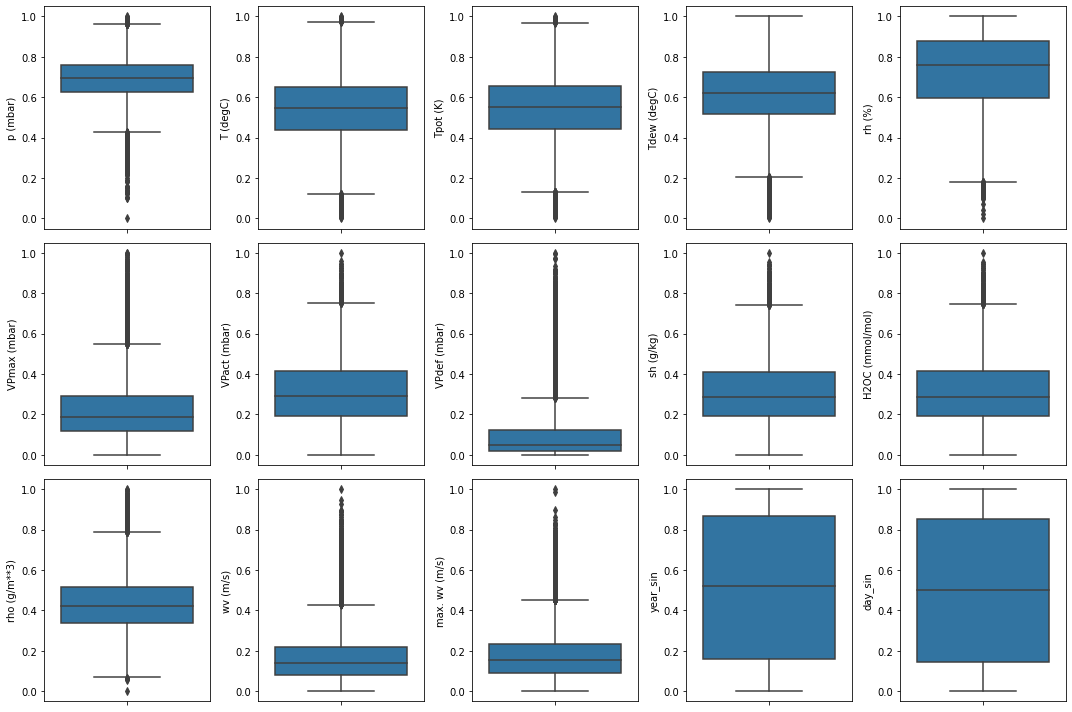

In [32]:
box_plot_all(df_train_sc.drop(['day_of_year', 'hour_in_day'], axis=1), nrows=3, ncols=5)

Looks good to me!

Now lets scale the test and validation data using the same scaler. Note that we are not fitting the scaler to the datasets, only transforming it.

In [33]:
df_test_sc = sc.transform(df_test)
df_test_sc = pd.DataFrame(df_test_sc, columns=df_test.columns, index=df_test.index)
df_validation_sc = sc.transform(df_validation)
df_validation_sc = pd.DataFrame(df_validation_sc, columns=df_validation.columns, index=df_validation.index)

## Creating the data window and inputs/labels

We need to organise the data into input sequences with corresponding label sequences.
To do this we will set:
* input_width - how many hours do we want to give the network to base the next prediction off?
* label_width - how many hours out do we want our model to predict?
* shift - how many hours after the input end do we want to start the prediction
* input_columns - what columns do we want the model to use?
* label_columns - what columns do we want it to predict?

For example, input_width = 72, label_width = 24 and shift = 12 would give the model 3 days of data for each prediction, the prediction would start 12 hours after the last input time, and the model would produce 1 day of data.

In [34]:
def get_label_indices(data, label_columns):
  label_col_indices = []
  for item in label_columns:
    label_col_indices.append(list(data.columns).index(item))
  return label_col_indices

In [35]:
def create_inputs_and_labels(data, input_width, label_width, shift, label_columns, input_columns):
  total_window_size = input_width + label_width + shift

  # creates input and labels of the correct width and columns
  inputs = []
  labels = []
  label_df = data[label_columns]
  input_df = data[input_columns]
  for i in range(0, len(data) - total_window_size):
    inputs.append(input_df[i: i + input_width])
    labels.append(label_df[i + input_width: i + input_width + label_width])
  return inputs, labels

In [36]:
# Create inputs and labels for training data
data = df_train_sc
input_width = 24
label_width = 24
shift = 0
input_columns = data.columns
label_columns = ['T (degC)']

inputs, labels = create_inputs_and_labels(data, input_width, label_width, shift, label_columns, input_columns)

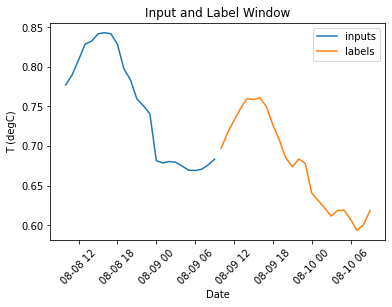

In [58]:
# plot an example of the window
plt.figure()
plt.plot(inputs[0][input_columns[1]])
plt.plot(labels[0][input_columns[1]])
plt.title('Input and Label Window')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.ylabel(input_columns[1])
plt.legend(['inputs', 'labels'])

In [38]:
# convert to arrays and reshape X_train
X_train = np.array(inputs)
X_train = X_train.reshape(len(inputs), input_width, len(input_columns))
y_train = np.array(labels)

We now want to do the same thing for the validation set so that we can track validation loss during training.

In [39]:
# Create inputs and labels for validation data
data = df_validation_sc
input_columns = data.columns
label_columns = ['T (degC)']

inputs, labels = create_inputs_and_labels(data, input_width, label_width, shift, label_columns, input_columns)

In [40]:
# convert to arrays and reshape
x_val = np.array(inputs)
x_val = x_val.reshape(len(inputs), input_width, len(input_columns))
y_val = np.array(labels)
validation_data = (x_val, y_val)

## LSTM model

For the model we will create a LSTM recurrent neural network.
The LSTM structure allows the model to store key information and use it later in the model, and it also avoids the vanishing/ exploding gradient problem.

In [41]:
num_features = df_train_sc.shape[1]
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(label_width*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([label_width, num_features])
])

In [60]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 32)            6400      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 408)               13464     
                                                                 
 reshape (Reshape)           (None, 24, 17)            0         
                                                                 
Total params: 28,184
Trainable params: 28,184
Non-trainable params: 0
_________________________________________________________________


In [42]:
MAX_EPOCHS = 20

def compile_and_fit(model, X_train, y_train, val_data, patience=4):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(X_train, y_train, epochs=MAX_EPOCHS,
                      validation_data=val_data,
                      callbacks=[early_stopping])
  return history

In [43]:
X_train.shape

(49042, 24, 17)

In [44]:
history = compile_and_fit(lstm_model, X_train, y_train, validation_data)

Epoch 1/20
1533/1533 [==============================] - 48s 27ms/step - loss: 0.0113 - mean_absolute_error: 0.0712 - val_loss: 0.0055 - val_mean_absolute_error: 0.0534
Epoch 2/20
1533/1533 [==============================] - 48s 31ms/step - loss: 0.0056 - mean_absolute_error: 0.0517 - val_loss: 0.0051 - val_mean_absolute_error: 0.0500
Epoch 3/20
1533/1533 [==============================] - 37s 24ms/step - loss: 0.0054 - mean_absolute_error: 0.0499 - val_loss: 0.0049 - val_mean_absolute_error: 0.0493
Epoch 4/20
1533/1533 [==============================] - 42s 28ms/step - loss: 0.0052 - mean_absolute_error: 0.0489 - val_loss: 0.0048 - val_mean_absolute_error: 0.0479
Epoch 5/20
1533/1533 [==============================] - 42s 27ms/step - loss: 0.0051 - mean_absolute_error: 0.0482 - val_loss: 0.0049 - val_mean_absolute_error: 0.0499
Epoch 6/20
1533/1533 [==============================] - 37s 24ms/step - loss: 0.0049 - mean_absolute_error: 0.0473 - val_loss: 0.0046 - val_mean_absolute_error:

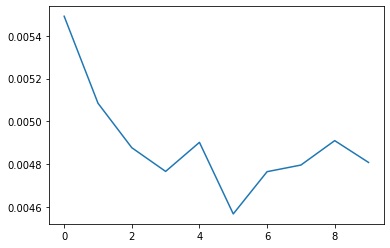

In [45]:
plt.plot(history.history['val_loss'])

## Making Predictions and evaluating the model

Now let's make some predictions on our test set and evaulate the model in more detail.

In [46]:
# Set window variables
data = df_test_sc
total_window_size = input_width + label_width + shift
data = df_test_sc
# creates input and labels of the correct width and columns
inputs = []
labels = []
for i in range(0, len(data) - total_window_size):
  inputs.append(df_test_sc[i: i + input_width])
  labels.append(df_test_sc[i + shift + input_width: i + shift + input_width + label_width])

In [47]:
# convert to arrays and reshape
x_test = np.array(inputs)
x_test = x_test.reshape(len(inputs), input_width, len(input_columns))
y_test = np.array(labels)

In [48]:
predictions = lstm_model.predict(x_test)

437/437 [==============================] - 8s 14ms/step


Let's plot some of the predictions. Note that the way the model is set up we will have prediction going out 24 hours after each of the inputs (which are themselves spaced out by the hour). 
The following graphs show some of the predictions made. They are one shot predictions meaning that they were given the previous 24 hours as input and then predicted the next 24 hours. It is clear that values closer to the last input (i.e. hours 1 - 5) have much better performance than later hours (which makes sense) 

In [49]:
def plot_24h_pred_vs_true(n_days):
  true_across = sc.inverse_transform(y_test[n_days*24,:,:])[:, 1]
  pred_across = sc.inverse_transform(predictions[n_days*24,:,:])[:, 1]
  plt.figure()
  plt.plot(pred_across)
  plt.plot(true_across)
  plt.legend(['Predicted', 'True'])
  plt.xlabel('Hours into prediction')
  plt.ylabel('Temperature')
  plt.title(f"{n_days} days after start date")

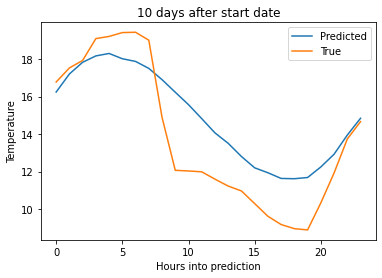

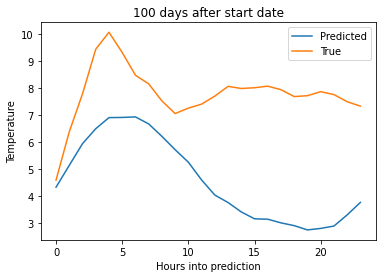

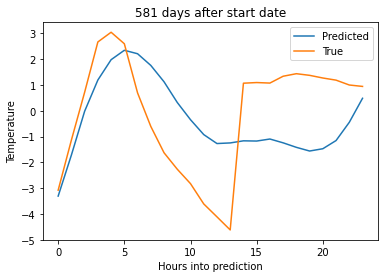

In [50]:
plot_24h_pred_vs_true(10)
plot_24h_pred_vs_true(100)
plot_24h_pred_vs_true(int(len(x_test)/24)-1)

Because we are forecasting 24 hours into the future, we will calculate an error for each timestep. i.e. we will have an error for 1 hour after the last input all the way to 24 hours after the last input. For this case we let's only look at temperature.

In [51]:
from sklearn.metrics import mean_absolute_error

In [52]:
def relative_root_mse(true_vals, temp_preds):
  df = pd.DataFrame()
  df['true'] = true_vals 
  df['preds'] = temp_preds
  df['diff'] = df['true'] - df['preds']
  df['diff_squared'] = df['diff']*df['diff']
  df['pred_squared'] = df['preds']*df['preds']
  df['per_diff'] = df['diff']/df['preds']
  num = df['diff_squared'].sum()
  den = df['pred_squared'].sum()
  squared_error = num/den
  rrmse = np.sqrt(squared_error)
  return rrmse

In [53]:
# relative root mean square errors
rrmse_scores = []
hours_in_future = list(range(label_width))
col_index = get_label_indices(data, label_columns)

for col in col_index:
  for i in hours_in_future:
    true_vals = sc.inverse_transform(y_test[:,i,:])[:, col]
    temp_preds = sc.inverse_transform(predictions[:,i,:])[:, col]
    rrmse = relative_root_mse(true_vals, temp_preds)
    rrmse_scores.append(rrmse)

Text(0.5, 1.0, 'RRMSE by hour into forecast')

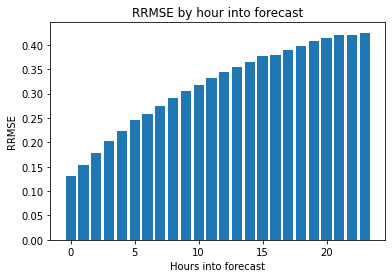

In [54]:
plt.figure()
plt.bar(hours_in_future, rrmse_scores, align='center')
plt.xlabel('Hours into forecast')
plt.ylabel('RRMSE')
plt.title('RRMSE by hour into forecast')

In [55]:
mae_scores = []
hours_in_future = list(range(label_width))
col_index = get_label_indices(data, label_columns)

for col in col_index:
  for i in hours_in_future:
    true_vals = sc.inverse_transform(y_test[:,i,:])[:, col]
    temp_preds = sc.inverse_transform(predictions[:,i,:])[:, col]
    mae = mean_absolute_error(true_vals, temp_preds)
    mae_scores.append(mae)

Text(0.5, 1.0, 'MAE by hour into forecast')

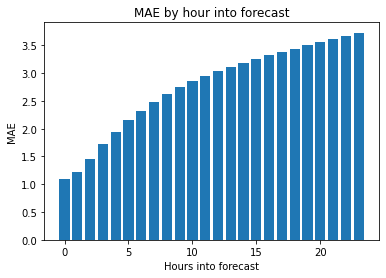

In [64]:
plt.figure()
plt.bar(hours_in_future, mae_scores, align='center')
plt.xlabel('Hours into forecast')
plt.ylabel('MAE')
plt.title('MAE by hour into forecast')

So on average we are 1 degree off on the temperature after 1 hour, up to 3.5 degrees after 24 hours.

We can also calculate the overall model performance which includes all the mae from each of the hours out that were predicted. Note that this is on scaled data, not unscaled! 

In [57]:
lstm_model.evaluate(x_test, y_test)

437/437 [==============================] - 4s 8ms/step - loss: 0.0931 - mean_absolute_error: 0.2533


[0.09307112544775009, 0.2532748878002167]